In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt



from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Ambil data File Excel

In [ ]:
# df = pd.read_csv('F:/Course/youtube/41. Eksponential Smoothing/retail_sales_used_car_dealers_us_1992_2020.csv', header=0, infer_datetime_format=True, parse_dates=[0], index_col=[0])
dataset = pd.read_excel(r'/content/drive/MyDrive/Collab Program/DataSet Penumpang Kereta Api.xlsx', sheet_name="Dataset")

print(dataset)

        NO    Periode    Total
0      1.0 2006-01-01  11504.0
1      2.0 2006-02-01  11705.0
2      3.0 2006-03-01  13066.0
3      4.0 2006-04-01  12657.0
4      5.0 2006-05-01  13312.0
..     ...        ...      ...
199  200.0 2022-08-01  23920.0
200  201.0 2022-09-01  25167.0
201  202.0 2022-10-01  27143.0
202  203.0 2022-11-01  26473.0
203  204.0 2022-12-01  29245.0

[204 rows x 3 columns]


# Menghapus NAN values

In [ ]:
new_df = dataset.dropna()
new_df = dataset.drop(dataset.columns[0], axis=1)

arrTotal = new_df['Total'].replace(',', '').astype(int)
arrPeriode = new_df['Periode']

new_df


,Periode,Total
0,2006-01-01,11504.0
1,2006-02-01,11705.0
2,2006-03-01,13066.0
3,2006-04-01,12657.0
4,2006-05-01,13312.0
...,...,...
199,2022-08-01,23920.0
200,2022-09-01,25167.0
201,2022-10-01,27143.0
202,2022-11-01,26473.0


In [ ]:
new_df.describe()

,Total
count,204.000000
mean,20992.338235
std,7992.236881
min,5476.000000
25%,15097.250000
50%,17255.000000
75%,27559.000000
max,38303.000000


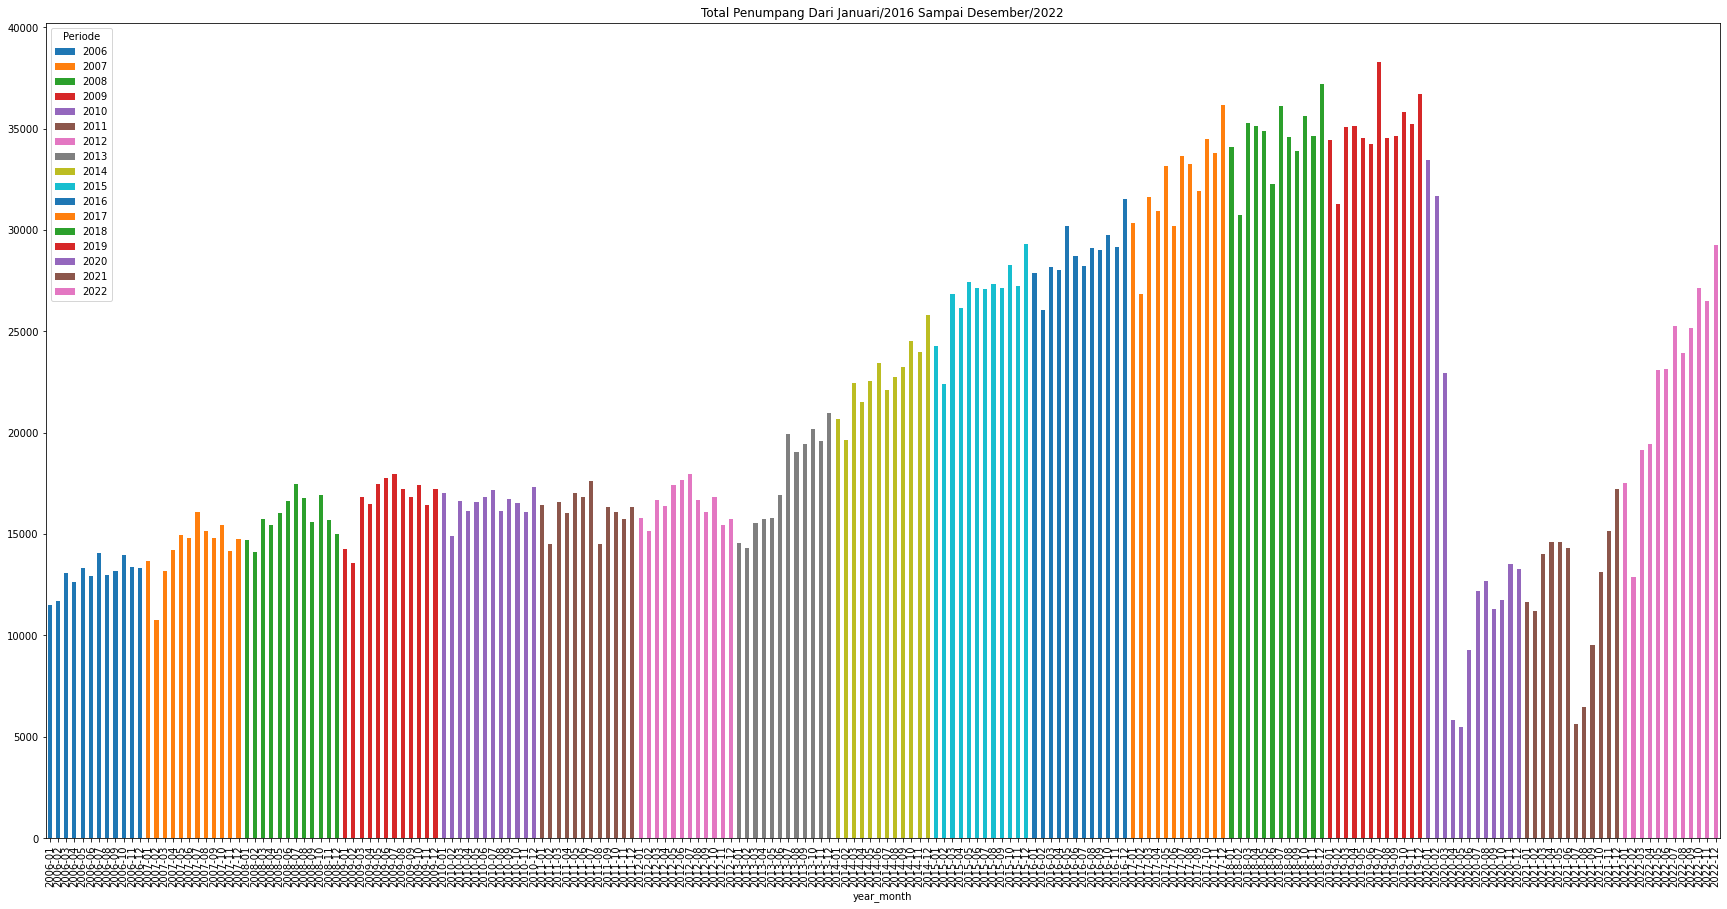

In [ ]:
new_df['year_month'] = new_df['Periode'].dt.strftime('%Y-%m')

crosstabYM = pd.crosstab(new_df['year_month'], new_df['Periode'].dt.year, values=new_df['Total'], aggfunc='sum')

crosstabYM.plot(kind='bar', stacked=True, figsize=(30,15))
plt.title('Total Penumpang Dari Januari/2016 Sampai Desember/2022')
plt.show()

In [ ]:
data_total = new_df['Total']
data_total.to_numpy()

array([11504., 11705., 13066., 12657., 13312., 12929., 14087., 12991.,
       13183., 13949., 13369., 13344., 13647., 10759., 13167., 14189.,
       14939., 14820., 16092., 15144., 14792., 15465., 14141., 14766.,
       14697., 14116., 15756., 15435., 16054., 16636., 17463., 16769.,
       15604., 16901., 15696., 15011., 14246., 13593., 16826., 16458.,
       17467., 17746., 17959., 17204., 16840., 17438., 16434., 17211.,
       17039., 14880., 16617., 16156., 16565., 16808., 17181., 16140.,
       16713., 16542., 16088., 17299., 16446., 14519., 16584., 16031.,
       17018., 16806., 17632., 14492., 16353., 16062., 15765., 16333.,
       15801., 15126., 16701., 16376., 17401., 17687., 17956., 16675.,
       16063., 16828., 15436., 15745., 14573., 14315., 15521., 15724.,
       15795., 16932., 19917., 19031., 19439., 20198., 19578., 20992.,
       20698., 19628., 22427., 21502., 22547., 23415., 22125., 22763.,
       23219., 24503., 23986., 25791., 24254., 22394., 26841., 26150.,
      

# Create Objective Function (Holt Wintes)

In [ ]:
# def holt_winters_additive(x, seasonal_periods, alpha, beta, gamma, n_preds):
def holt_winters_additive(x, seasonal_periods, params, n_preds):
    """implement Holt-Winters additive method for time series forecasting
    
    Parameters:
    x (list): Time series data
    seasonal_periods (int): Number of seasons in a year
    alpha (float): Smoothing parameter for level
    beta (float): Smoothing parameter for trend
    gamma (float): Smoothing parameter for seasonal component
    n_preds (int): Number of periods to forecast
    
    Returns:
    tuple: (forecast, mse, rmse)
            forecast (list): Forecasted values
            rmse (float): Root Mean Squared Error of the model
    """

    # Initial params smoothing holt winters
    alpha, beta, gamma = params

    # Initialize level, trend, and seasonal components
    level = sum(x[:seasonal_periods]) / float(seasonal_periods)
    trend = (sum(x[seasonal_periods:2*seasonal_periods]) - sum(x[:seasonal_periods])) / seasonal_periods**2
    seasonal_components = [(x[i] - level) for i in range(seasonal_periods)]
  

    # Initialize forecast and RMSE
    forecast = []
    MSE = 0
    RMSE = 0
    
    # Run Iterasi
    for i in range((len(x))):
        # Calculate forecast for next time period
        last_level = level
        last_trend = trend
        last_seasonal = seasonal_components[i % seasonal_periods]


        if(i < len(x) - n_preds):
          forecast_value = level + trend + last_seasonal
        
          # Add forecast value to the list
          forecast.append(forecast_value)
          
          # Update level, trend, and seasonal components
          level = alpha * (x[i+seasonal_periods] - last_seasonal) + (1 - alpha) * (last_level + last_trend)
          trend = beta * (level - last_level) + (1 - beta) * last_trend 
          seasonal_components[i % seasonal_periods] = gamma * (x[i+seasonal_periods] - level) + (1 - gamma) * last_seasonal
          
          # Update RMSE
          error = x[i+seasonal_periods] - forecast_value
          absolute_error = abs(error)
          squared_error = absolute_error**2

          MSE += squared_error
          # MSE += (x[i+seasonal_periods] - forecast_value) ** 2
        else:
          n_preds_temp = abs((len(x) - i) - (n_preds+1))

          forecast_value = level + (n_preds_temp*trend) + last_seasonal
        
          # Add forecast value to the list
          forecast.append(forecast_value)

    # Calculate final MSE & RMSE
    MSE     = MSE / (len(x) - n_preds)
    RMSE    = MSE ** 0.5

    
    # return (forecast, MSE, RMSE)
    return RMSE

# # Example usage
# x = data_total
# seasonal_periods = 12
# alpha = 0.6
# beta = 0.1
# gamma = 0.4
# n_preds = 12

# forecast, mse, rmse = holt_winters_additive(x, seasonal_periods, alpha, beta, gamma, n_preds)

# print("Forecasted values:", forecast)
# print("MSE:", mse)
# print("RMSE:", rmse)


# Declare Method Particle Swarm Optimization (PSO)

In [ ]:
# # Contoh Obbjective Function
# def objective_function(params):
#     x, y, z = params
#     return x+y+z
    
def ParticleSwarmOptimization(PSOParams,HoltWintersParams):
    num_particles = PSOParams['num_particles'] # Jumlah Partikel Dalam Swarm
    max_iterations = PSOParams['max_iterations'] # Max Iteration
    num_dimensions = PSOParams['num_dimensions'] # Dimensi Ruang Pencarian
    lb = PSOParams['lb'] # Batas bawah ruang pencarian
    ub = PSOParams['ub'] # Batas atas ruang pencarian
    w = PSOParams['w'] # Inertia weight
    c1 = PSOParams['c1'] # Cognitive parameter
    c2 = PSOParams['c2'] # Social parameter


    x = HoltWintersParams['x'] # # DataSet Timeseries
    seasonal_periods = HoltWintersParams['seasonal_periods']
    n_preds = HoltWintersParams['n_preds']

    # Initial Partikel Random
    particles = np.random.uniform(lb, ub, (num_particles, num_dimensions))
    velocities = np.zeros((num_particles, num_dimensions))

    p_best = particles.copy() 
    best_scores = np.ones(num_particles) * float('inf')

    global_best_position = None
    global_best_score = float('inf')

    # Run Iterasi
    for i in range(max_iterations):

        # Evaluasi fungsi tujuan untuk setiap partikel
        # scores = np.array([objective_function(params) for params in particles])
        scores = np.array([holt_winters_additive(data_total, seasonal_periods, params, n_preds) for params in particles])

        for j in range(num_particles):
            if scores[j] < best_scores[j]:
                p_best[j] = particles[j]
                best_scores[j] = scores[j]
        
        # Perbarui posisi dan skor terbaik global
        if np.min(scores) < global_best_score:
            global_best_position = particles[np.argmin(scores)]
            global_best_score = np.min(scores)
        
        # print('DATA KE : ',i,  global_best_score)

        # Perbarui kecepatan dan posisi partikel
        r1 = np.random.random((num_particles, num_dimensions))
        r2 = np.random.random((num_particles, num_dimensions))
        cognitive = c1 * r1 * (p_best - particles)
        social = c2 * r2 * (global_best_position - particles)
        velocities = w * velocities + cognitive + social
        particles = particles + velocities
        particles = np.clip(particles, lb, ub) # Pastikan posisi partikel berada dalam batas

    # Hasil
    print("Best solution found:")
    print(global_best_position)
    print("Best score: ", global_best_score)

# Optimasi Parameter Pemulusan Holt Winter

In [ ]:
PSOParams = {
    "num_particles"     : 20, 
    "max_iterations"    : 100, 
    "num_dimensions"    : 3,
    "lb"                : 0,
    "ub"                : 1,
    "w"                 : 1,
    "c1"                : 1,
    "c2"                : 1,
}

HoltWintersParams = {
    "x"                 : data_total, # Dataset Time Series
    "seasonal_periods"  : 12,
    "n_preds"           : 12
}


ParticleSwarmOptimization(PSOParams,HoltWintersParams)

Best solution found:
[0.94646283 0.         1.        ]
Best score:  2093.44406728324


In [ ]:
# from sklearn.metrics import mean_squared_error


# actual_values = np.array([13647, 10759, 13167, 14189, 14939, 14820, 16092, 15144, 14792, 15465, 14141, 14766, 14697, 14116, 15756, 15435, 16054, 16636, 17463, 16769, 15604, 16901, 15696, 15011, 14246, 13593, 16826, 16458, 17467, 17746, 17959, 17204, 16840, 17438, 16434, 17211, 17039, 14880, 16617, 16156, 16565, 16808, 17181, 16140, 16713, 16542, 16088, 17299, 16446, 14519, 16584, 16031, 17018, 16806, 17632, 14492, 16353, 16062, 15765, 16333, 15801, 15126, 16701, 16376, 17401, 17687, 17956, 16675, 16063, 16828, 15436, 15745, 14573, 14315, 15521, 15724, 15795, 16932, 19917, 19031, 19439, 20198, 19578, 20992, 20698, 19628, 22427, 21502, 22547, 23415, 22125, 22763, 23219, 24503, 23986, 25791, 24254, 22394, 26841, 26150, 27450, 27118, 27077, 27351, 27125, 28280, 27253, 29328, 27886, 26058, 28156, 28000, 30176, 28730, 28216, 29125, 29019, 29765, 29178, 31530, 30359, 26837, 31612, 30934, 33157, 30181, 33669, 33255, 31921, 34498, 33798, 36140, 34107, 30721, 35272, 35135, 34877, 32270, 36089, 34560, 33878, 35602, 34637, 37197, 34435, 31282, 35068, 35106, 34514, 34261, 38303, 34542, 34615, 35814, 35228, 36710, 33472, 31679, 22949, 5813, 5476, 9272, 12205, 12679, 11295, 11768, 13523, 13262, 11631, 11223, 13995, 14590, 14627, 14313, 5646, 6479, 9510, 13139, 15161, 17207, 17499, 12857, 19133, 19436, 23114, 23160, 25272, 23920, 25167, 27143, 26473, 29245])
# predicted_values = np.array([11613.89583, 13266.64042, 13204.47983, 12852.16680, 14468.65158, 14555.46640, 16075.66434, 15193.92366, 15557.43197, 16019.70937, 15229.13777, 14608.22086, 13254.61752, 13747.50333, 15899.91228, 15790.90551, 16238.82083, 15846.00490, 17619.69693, 16591.08211, 16958.03141, 17046.76620, 16386.64998, 16197.85974, 14156.61856, 13498.31091, 15220.45032, 16048.16997, 16949.81245, 17143.20489, 18650.90699, 17320.39269, 17213.67331, 18090.79643, 17015.70989, 16795.85578, 15999.10143, 16048.07018, 17314.64306, 16491.29170, 16840.49081, 16401.86521, 17402.51094, 16292.63247, 15967.14585, 17382.63892, 16106.26336, 16317.82324, 15928.46048, 15247.20862, 16815.82830, 16320.75241, 16700.38600, 16755.81244, 17450.23873, 16625.31269, 15168.30354, 16532.72138, 15571.52976, 16044.39756, 15098.11114, 14272.67303, 16908.45089, 16459.01222, 17112.55159, 17158.62354, 18240.63940, 16817.10152, 17256.81360, 16957.66101, 16356.24236, 16158.14708, 14797.03513, 13323.83564, 15765.18464, 15204.00504, 16205.35199, 15755.17373, 17019.72547, 17642.60538, 19038.63435, 20168.19762, 19847.47568, 20471.53335, 20107.42207, 19772.87364, 21722.23302, 22296.91925, 22725.79343, 23047.72361, 24432.46893, 21709.44916, 22744.76378, 23862.06805, 23899.51593, 24924.27437, 24860.64597, 23699.76720, 25028.55558, 26034.38176, 27169.27410, 27942.97374, 28201.56142, 26814.17545, 27503.88652, 28141.92366, 27764.71037, 28495.26299, 28113.33483, 27028.77489, 29038.16360, 27974.74738, 28895.43023, 29965.70755, 29778.86018, 28216.95805, 28827.80017, 29769.72274, 29073.41575, 30296.38602, 29916.95447, 29086.81707, 30237.96049, 30703.82713, 31990.98248, 32625.72055, 31624.37665, 32802.01369, 33177.52905, 33285.00432, 33475.41824, 35161.51236, 34638.72706, 32871.57475, 34745.98180, 34553.03690, 36255.12887, 34687.13956, 34323.77269, 34965.47982, 34387.25472, 35217.91668, 34598.48035, 36032.00181, 35203.59879, 32845.20580, 35345.42923, 34476.30035, 35693.21701, 33890.06530, 35847.73833, 36576.57164, 34926.96067, 35953.44399, 34867.70029, 36596.93236, 34687.28567, 31766.23240, 35278.81149, 26521.29830, 12563.61408, 5026.56913, 7438.02268, 6769.80549, 8572.99137, 10040.41650, 8859.82750, 12094.37770, 9631.35213, 8039.06838, 10971.12394, 10422.07736, 15398.82040, 15672.87170, 16676.60583, 7636.75320, 5189.96355, 8053.12186, 10154.72607, 13853.95737, 13784.54158, 14462.75169, 15260.12950, 16219.20783, 20593.52667, 23705.01658, 24655.38822, 25887.39753, 25486.56392, 27065.41695, 27225.73000, 27935.92426])

# # calculate the difference between predicted and actual values
# differences = actual_values - predicted_values

# # square the differences and calculate the mean
# mse = np.mean(differences ** 2)

# # take the square root of the mean squared error to get the RMSE
# rmse = np.sqrt(mse)

# print('Manual RMSE : ',rmse)

# rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
# print('Library RMSE : ',rmse)

Manual RMSE :  2485.2255775455637
Library RMSE :  2485.2255775455637


In [ ]:
# # BACKUPPP

# import numpy as np

# # Define the objective function to be optimized
# def objective_function(x):
#     return np.sum(x**2) # Example objective function: f(x) = x1^2 + x2^2 + ... + xn^2

# # Set the PSO parameters
# num_particles = 10 # Number of particles in the swarm
# max_iterations = 50 # Maximum number of iterations
# num_dimensions = 3 # Dimensionality of the search space
# lb = 0 # Lower bound of the search space
# ub = 1 # Upper bound of the search space
# w = 1 # Inertia weight
# c1 = 1 # Cognitive parameter
# c2 = 1 # Social parameter

# # Initialize the particles randomly
# particles = np.random.uniform(lb, ub, (num_particles, num_dimensions))
# velocities = np.zeros((num_particles, num_dimensions))
# best_positions = particles.copy()
# best_scores = np.ones(num_particles) * float('inf')
# global_best_position = None
# global_best_score = float('inf')

# # Run the PSO algorithm
# for i in range(max_iterations):
#     # Evaluate the objective function for each particle and update its best position
#     scores = objective_function(particles)
#     for j in range(num_particles):
#         if scores < best_scores[j]:
#             best_positions[j] = particles[j]
#             best_scores[j] = scores

#     # Update the global best position and score
#     if np.min(scores) < global_best_score:
#         global_best_position = particles[np.argmin(scores)]
#         global_best_score = np.min(scores)
    
#     # Update the velocities and positions of the particles
#     r1 = np.random.random((num_particles, num_dimensions))
#     r2 = np.random.random((num_particles, num_dimensions))

#     cognitive = c1 * r1 * (best_positions - particles)
#     social = c2 * r2 * (global_best_position - particles)
#     velocities = w * velocities + cognitive + social
    
#     particles = particles + velocities
#     particles = np.clip(particles, lb, ub) # Ensure particle position is within bounds (batas diantara blunds)

# # Print the best solution found
# print("Best solution found:")
# print(global_best_position)
# print("Best score: ", global_best_score)